# **TP Wavelets**

In this TP, we will work on some fundamental concepts in Wavelets and compression of images.

First we'll briefly check the limitations of the Fourier transform. We'll then check some fundamental properties of a family of Wavelets and compute the Wavelet transform of a very simple signal. In the second part of the TP, we will use the DWT to compress and image.

Make sure to sequentially run all the cells in each section, so that the intermediate variables / packages will carry over to the next cell

We recommend you save a copy of this colab in your drive so you don't lose progress!

**Note 1:** As mentioned in the course and since there's not any policy regarding ChatGPT at Télécom level yet, you can use it. However, using ChatGPT without understanding their outputs is not OK, and will be penalized accordingly in your grade. Please be sure of all the functions you'll use.

**Note 2:** Several points have associated questions. When answering these questions, all responses should be properly justified. ChatGPT answers are very easy to spot.

**Note 3:** Always plot the functions and outputs you're generating. If the output or function is not properly plotted/shown, this will reduce points in your grade.

# Setup
First, we install PyWavelets

In [1]:
!pip install PyWavelets

In [2]:
import pywt

pywt.__version__

'1.4.1'

# Important
Google Colab is an interesting tool to try things out quickly. However, Google Colab and more general Notebooks are not meant to be an Integrated Development Environment (IDE). For a real job, please use an actual IDE like PyCharm or VS Code.

# Limitation of the Fourier Transform
*   Create a sinusoidal signal of 2.5 seconds of duration.
*   Set up a sampling rate of 20kHz. The signal should be divided in 5 parts of 0.5 seconds of duration each.
*  The signal should have the following frequencies in this order {10 Hz, 30 Hz, 60 Hz, 30 Hz, 10 Hz}.

In [3]:
# Your code here
import numpy as np
import scipy.signal
Fs=20000
signal=np.zeros(int(2.5*Fs))
frequency=np.array([10,30,60,30,10])
for i in range(len(frequency)):
    signal[int(i*0.5*Fs):int((i+1)*0.5*Fs)]=np.sin([frequency[i]*t/int(0.5*Fs) for t in range(int(i*0.5*Fs),int((i+1)*0.5*Fs))])
signal

array([ 0.        ,  0.001     ,  0.002     , ..., -0.26526857,
       -0.26430426, -0.26333969])

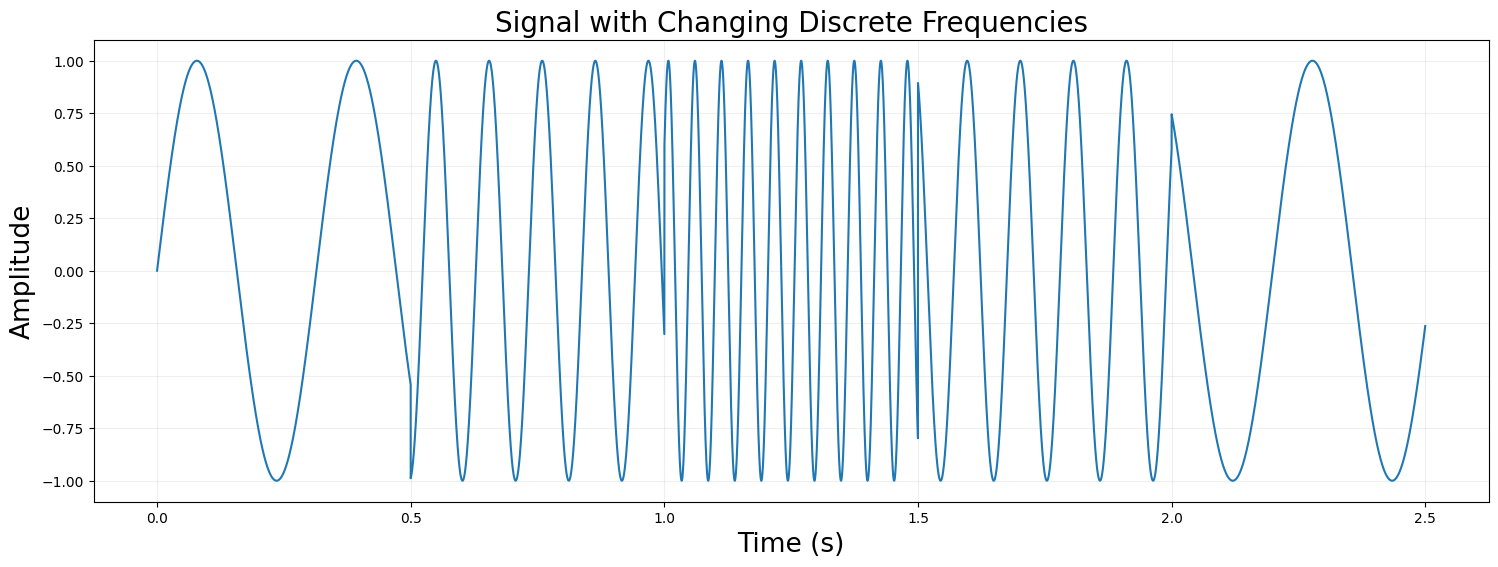

In [4]:
import matplotlib
import matplotlib.pyplot as plt

font_size = 20
time=[t/Fs for t in range(int(Fs*2.5))]
plt.figure(figsize=(18, 6))
plt.plot(time, signal, linewidth=1.5)
plt.title('Signal with Changing Discrete Frequencies', fontsize=font_size)
plt.xlabel('Time (s)', fontsize=font_size-1)
plt.ylabel('Amplitude', fontsize=font_size-1)
plt.grid(alpha=0.2)

#The transition are quite sharp but i had no idea how to smoothen them

Now, you should compute the Discrete Fourier Transform of the signal. You can use any library from Python you prefer. You might need to cut the x-axis in the Fourier transform up to 100 Hz in the visualization. Please check https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html and https://numpy.org/doc/stable/reference/generated/numpy.fft.fftfreq.html

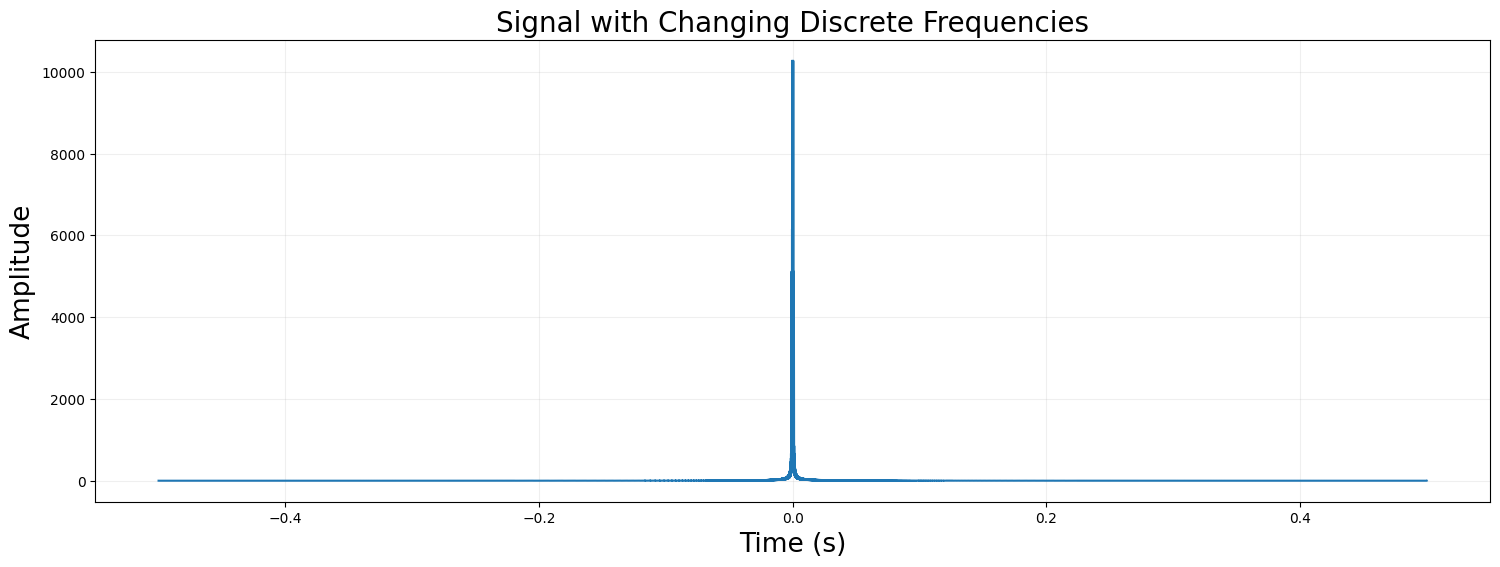

In [5]:
# Your code here
fftSignal=np.fft.fft(signal,len(signal))

plt.figure(figsize=(18, 6))
nu=[i/len(time)-1/2 for i in range(len(time))]
plt.plot(nu,np.abs(np.fft.fftshift(fftSignal)), linewidth=1.5)
plt.title('Signal with Changing Discrete Frequencies', fontsize=font_size)
plt.xlabel('Time (s)', fontsize=font_size-1)
plt.ylabel('Amplitude', fontsize=font_size-1)
plt.grid(alpha=0.2)

**QUESTIONS**

1) Does the established sampling rate satisfy the Nyquist-Shannon sampling theorem to avoid aliasing? Please justify.

2) What can you say from the signal looking **only** at the Fourier transform?

3) Can you be certain about the location of some frequency component in the time domain? Why?

**YOUR ANSWERS HERE:**

1) The Nyquist-Shannon sampling theorem ensure that we can perfectly reconstruct the sampled signal if the sampling frequency is greater than 2 times the highest frequency of the signal which is the case here since $20000>2*60$

2) Here, only looking at the graph we can't distinguish the multiple frequencies inside the signal. We can only know that some low frequency are in the sampled signal.

3) In the time domain you cannot be certain about some frequency component because, to be certain, you need to know a window where the frequenct don't change, to calculate the frequency of the signal. Since we suppose that we don't know when the signal frequency change we can't evaluate their values.

# **Mother Wavelet**
As we saw in the course, a wavelet is not just a function but a whole family of functions that satisfy certain requirements. In this part of the TP we're gonna work with the Morlet wavelet defined as follows: $\Psi(t)=k e^{iw_0t}e^{-\frac{1}{2}(\frac{t}{\sigma})^2}$. Please generate a Morlet wavelet in Python **WITHOUT using PyWavelets** with the following parameters:

-Center frequency of the wavelet = 10 Hz

-Sampling rate $\eta$ = 20000 Hz

-$k=\frac{1}{\sqrt{\eta}}$

-$\sigma = 0.1$

You can generate the wavelet between -1 and 1 seconds, so the time duration of the wavelet is 2 seconds. For this part, you just need to generate the real part of the wavelet.

Text(0, 0.5, 'Amplitude')

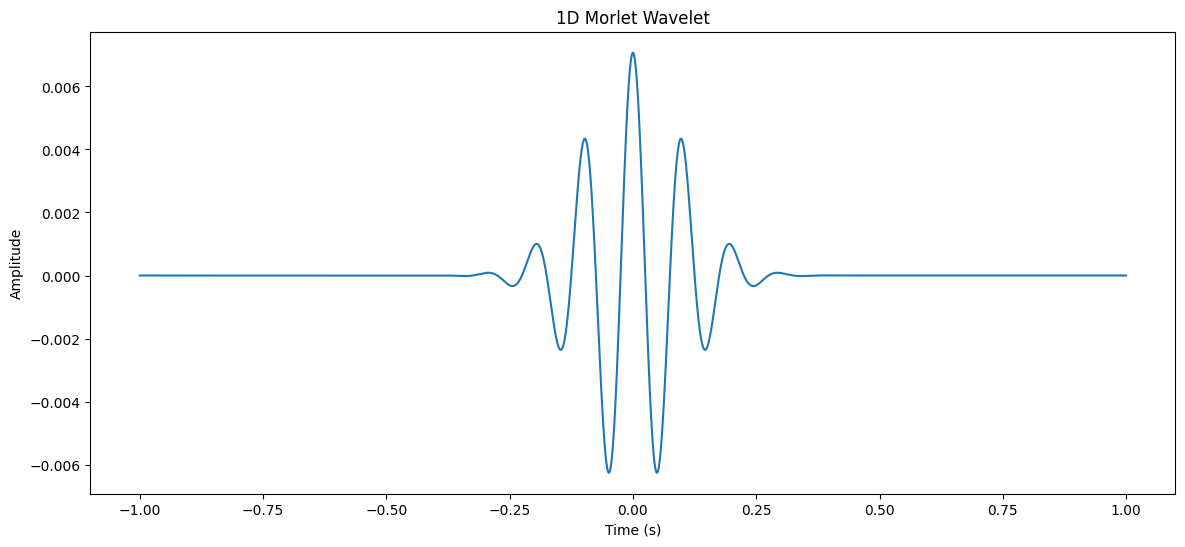

In [6]:
# Your code here
def Morlet(k,w_0,sigma,time):
    ''' Compute a morlet wavelet of parameters kw_0,sigma for the value of time given in the array named time'''
    return k*np.exp([1j*w_0*t-1/2*(t/sigma)**2 for t in time])
time=[t/Fs-1 for t in range(Fs*2)]
morlet_wavelet=Morlet(1/np.sqrt(Fs),2*np.pi*10,0.1,time)


# Plot the real part of the Morlet wavelet in 
plt.figure(figsize=(14, 6))

plt.plot(time,np.real(morlet_wavelet), linewidth=1.5)
plt.title('1D Morlet Wavelet')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

Please show that the mother wavelet we just created satisfies the admissibility and the finite energy conditions:

In [7]:
# Your code here
print(np.abs(np.trapz(morlet_wavelet)))           #amissibility condition, should be close to zero

9.483648910534775e-08


In [8]:
np.trapz([m*np.conj(m) for m in morlet_wavelet])  #finite energy

(0.1772453850905516+0j)

**Note:** In real life, you have to deal with finite-precision related problems. Therefore, if for the admissibility condition you don't have exactly the value you were expecting for, don't worry.

# **Convolution**

As we saw in the course, we need a measure of similarity to compute the wavelet transform. We also saw that we can easily compute the shift in time and similarity calculation with the 1-D convolutions.

* Generate a chirp sinusoidal signal from -5 to 5 seconds with an initial frequency of 5 Hz and final frequency of 15 Hz and sampling rate of 20kHz:

Text(0.5, 0, 'Time')

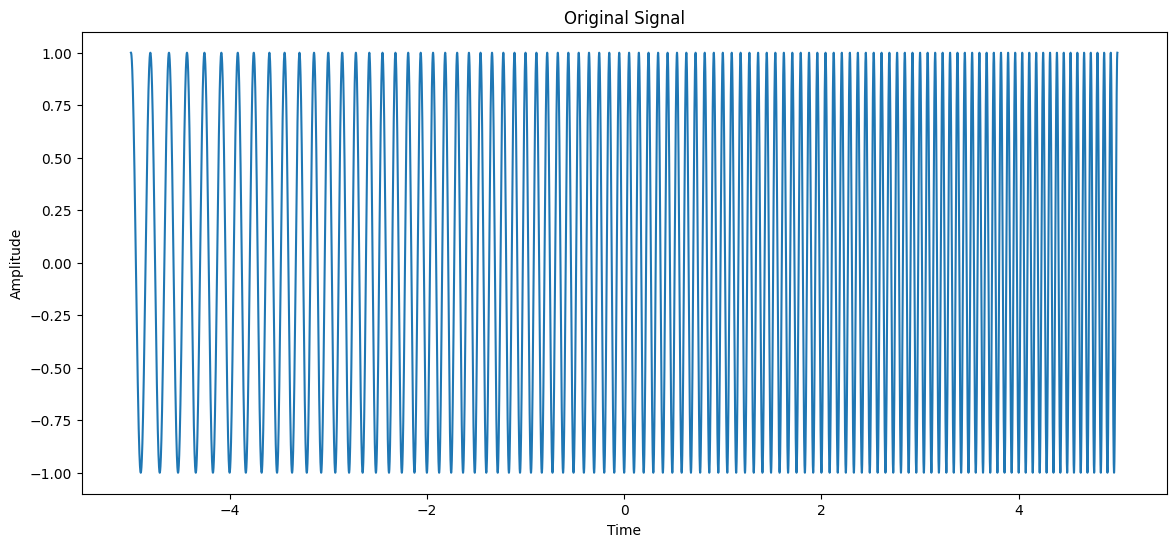

In [9]:
# Your code here
signal=scipy.signal.chirp([t/Fs for t in range(10*Fs)],5,10,15)
time_signal=[-5+t/Fs for t in range(10*Fs)]
plt.figure(figsize=(14, 6))
plt.plot(time_signal, signal)
plt.title('Original Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time')

Now create a Morlet wavelet with the following parameters:

* Center frequency of the wavelet = 10 Hz

* Sampling rate $\eta$ = 20000 Hz

* $k=\frac{1}{\sqrt{\eta}}$
* $\sigma = 0.2$
* Duration = 2 seconds


Text(0.5, 0, 'Time')

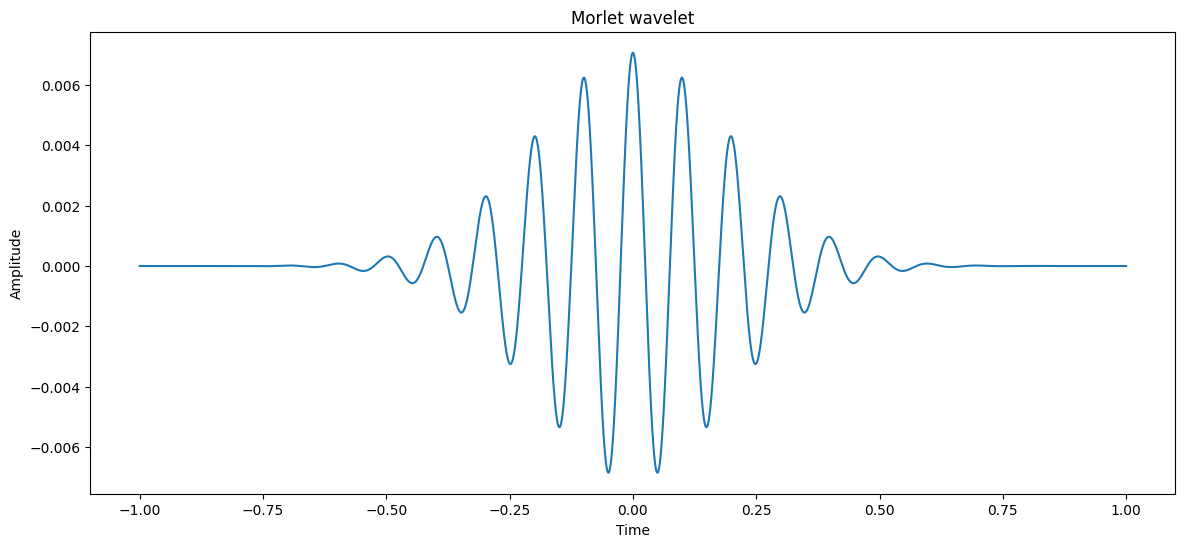

In [10]:
# Your code here
time=[t/Fs-1 for t in range(2*Fs)]
morlet_wavelet=Morlet(1/np.sqrt(Fs),2*np.pi*10,0.2,time)
plt.figure(figsize=(14, 6))
plt.plot(time, np.real(morlet_wavelet))

plt.title('Morlet wavelet')
plt.ylabel('Amplitude')
plt.xlabel('Time')

Compute the convolution between the signal and $Re(\Psi(t))$. For reference on how to perform convolution with scipy 'convolve' function, please check https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html

Text(0, 0.5, 'Amplitude')

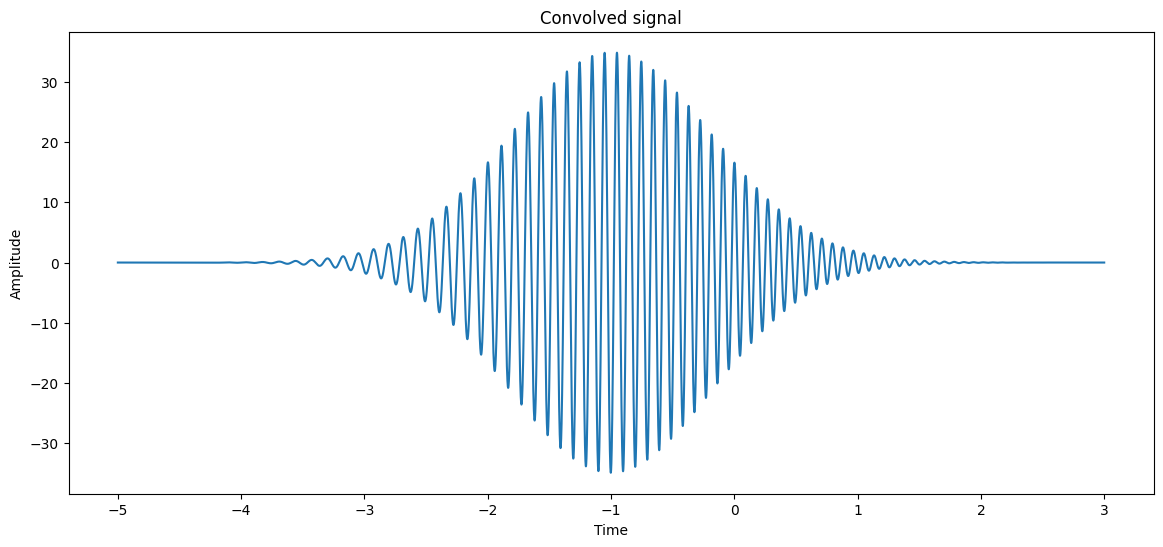

In [11]:
# Your code here
convolved_signal=scipy.signal.convolve(signal,np.real(morlet_wavelet),mode='valid',method='fft')

plt.figure(figsize=(14, 6))
plt.plot(time_signal[:len(convolved_signal)], convolved_signal)
plt.title('Convolved signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

There are some points where the convolution is zero, even in regions of high similarity between the wavelet and the signal. **Is this OK?** If it's not, propose a solution to that.

It is not ok because it show that we are lacking previous information after performing the transform.
It is due to the fact that we only used the real part of our wavelet.
So we need to take also the imaginary part in the previous convolution.

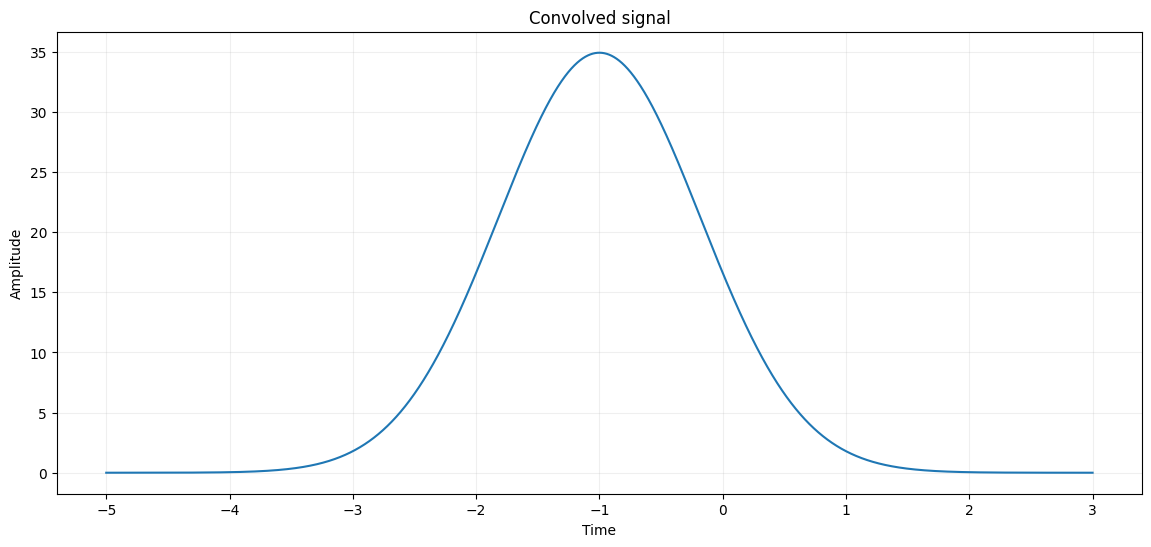

In [12]:
# Your code here
convolved_signal=scipy.signal.convolve(signal,morlet_wavelet,mode='valid',method='fft')
plt.figure(figsize=(14, 6))
plt.plot(time_signal[:len(convolved_signal)], np.abs(convolved_signal))
plt.title('Convolved signal')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.grid(alpha=0.2)

# **Image Compression**
For this part, we'll use the Discrete Wavelet Transform (DWT) implemented as a filter bank to do image compression. The first step is to have an image to compress. For doing so you can use the following piece of code to download an image of Trudy.

In [13]:
#!wget https://raw.githubusercontent.com/jhonygiraldo/jhonygiraldo.github.io/main/Trudy_for_compression.jpeg

**Visualize image:** With the following code you can visualize the image. If you're using Google Collab, most probably you already have the open cv library installed. If you're using Jupyter Notebook for example, you'll have to install open cv if it's not already installed.

In [14]:
# Let us define a function for visualizing images
def show_image(image, title='Input Image', font_size=12,fig_size = (10, 10)):
  #A function that uses matplotlib to show grayscale images
  plt.figure(figsize=fig_size)
  plt.imshow(image, cmap='gray')
  plt.title(title, fontsize=font_size)
  plt.axis('off')

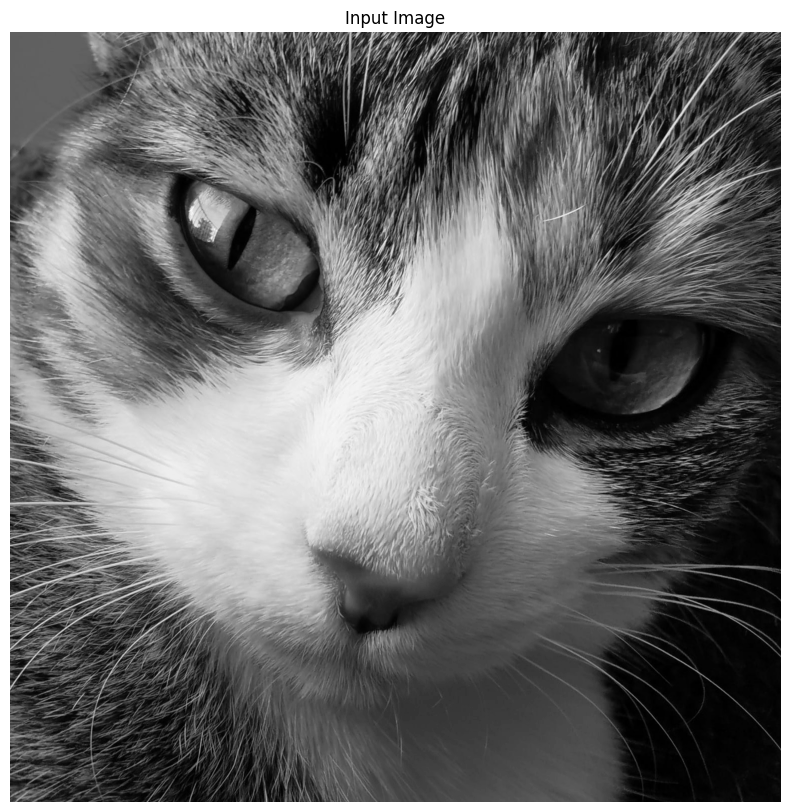

In [15]:
import cv2

# Load your image as a grayscale
input_image = cv2.imread('Trudy_for_compression.jpeg', cv2.IMREAD_GRAYSCALE)
# Display the original image
show_image(input_image, 'Input Image')

If you use some wavelet function (Biorthogonal 1.3 in this case), the 1-level 2D wavelet decomposition of our input image is given as follows:

In [16]:
# # You can see a list of wavelet families
import pywt
pywt.families()

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

In [17]:
# For each family, you can list the available wavelets
pywt.wavelist(family='bior', kind='all')

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8']

In the previous image we applied a threshold in the wavelet coefficients for visualization purposes. **Please explain the meaning of each of these 4 images**.

**YOUR ANSWER HERE:**

The previous image is obtained with 3 other images based on the original uncompressed image: 
- The first image is obtained by applying an horizontal wavelet filter to the original image
- The second image is obtained by applying a vertical wavelet filter to the original image
- The third image is obtained by applying a diagonal wavelet filter to the original image
Then the last image (which is the image showed above), is obtained by applying a threshold on the three filtered images and then using the inverse wavelet transform.
We apply a threshold because we can assume most of the coefficients of the computed image are close to zero so we can remember only those which are far appart from zero to reduce memory complexity.

Now, you should compute the six-levels 2D wavelet decomposition of the input image with a Daubechies wavelet with six vanishing moments using the PyWavelet library. Please check https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-decomposition-using-wavedec2

In [18]:
# Your code here
level_list=pywt.wavedec2(input_image, 'db12')
level_list[1][0]

array([[-2.92495914e-01, -2.99992961e-01, -2.93242860e-01, ...,
         2.56128797e+01,  3.85504948e+01,  3.59937235e+01],
       [ 9.99673624e-02,  1.01684173e-01,  9.45045614e-02, ...,
        -1.59138854e+01, -2.28277609e+01, -2.20024511e+01],
       [-6.00368084e-01, -6.03809251e-01, -6.04986236e-01, ...,
        -3.62712640e+01, -5.18062301e+01, -5.29357110e+01],
       ...,
       [-3.63163599e+02, -4.09724210e+02, -4.12205329e+02, ...,
         1.36858865e+02,  2.65901064e+02,  3.86795007e+02],
       [ 3.63227720e+02,  3.64911187e+02,  3.61989515e+02, ...,
        -1.69226462e+02, -1.64454850e+02, -2.57096585e+02],
       [-2.18444659e+02, -2.14568205e+02, -2.01396614e+02, ...,
        -2.77753796e+02, -2.58833846e+02, -2.47620862e+02]])

* Set a threshold of value of 100 and take to zero the values less than that in the 2D wavelet decomposition. **Note:** You should only threshold the outputs of the high-pass filters.



In [19]:
# Your code here
threshold=100
def apply_threshold(threshold,array_list):
    ''' Given an array of images named array_list, apply the threshold threshold on each of the image contained by the array.'''
    for array in array_list:
        for i in range(len(array)):
            for j in range(len(array[i])):
                if array[i][j]<threshold:
                    array[i][j]=0
    return array_list 

level_list=[level_list[0] if k==0 else apply_threshold(threshold,level_list[k]) for k in range(len(level_list))]
level_list

[array([[6109.39948088, 6106.07216043, 6106.28794379, ..., 4417.74575061,
         4566.22410114, 4336.62904793],
        [6109.03014353, 6105.74961359, 6106.010698  , ..., 4560.48979616,
         4768.3092969 , 4505.12412346],
        [6110.0761136 , 6106.95333624, 6107.23708634, ..., 4556.72138422,
         4746.80172403, 4474.52767966],
        ...,
        [4902.30308884, 5015.54803683, 4998.29730269, ...,  524.88178927,
          553.3184085 ,  570.54871458],
        [5278.95918343, 5411.91581268, 5391.91601074, ...,  422.27899221,
          413.99216128,  374.1541818 ],
        [5715.88229875, 5921.77981527, 5893.38147185, ...,  475.88177643,
          468.32902044,  460.88879188]]),
 (array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
          

* Compute the IDWT to reconstruct the image after the "compression". Check https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-reconstruction-using-waverec2 as a reference.

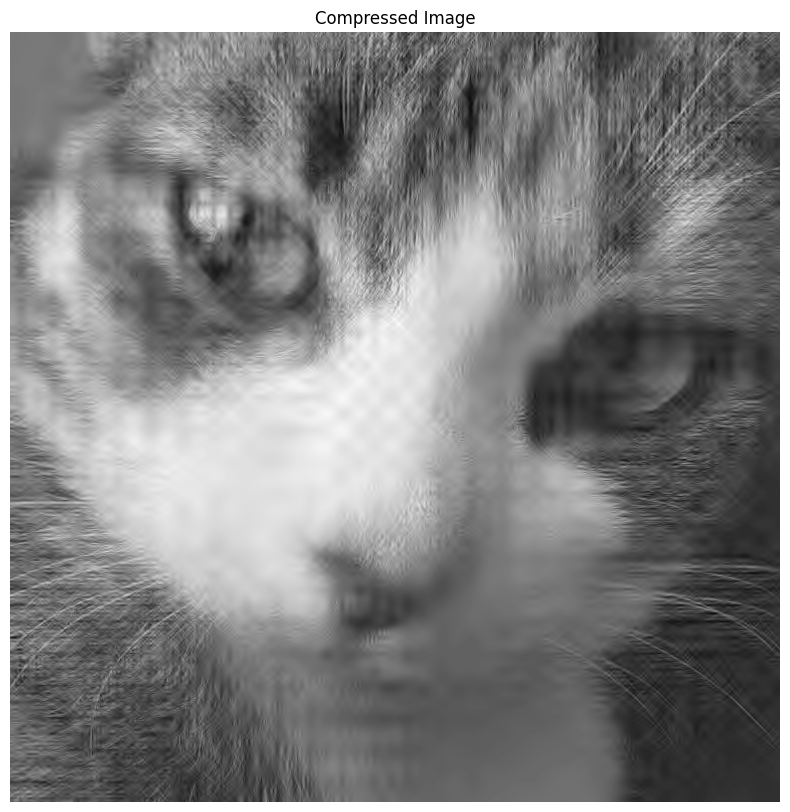

In [20]:
# Your code here
compressed_image=pywt.waverec2(level_list, 'db12')
#plot compressed image
show_image(compressed_image, 'Compressed Image')

What's the compression ratio?

In [21]:
# Your code here
#We only need to keep in memory the wevelet transform to reconstruct the image. We need to count the number of value we need to remember.
def count_non_zero(array_list):
    ''' Given an array of images, count the number of non zero values appearing over all the images.'''
    n=0
    for array in array_list:
        for i in range(len(array)):
            for j in range(len(array[i])):
                if array[i][j]!=0:
                    n+=1
    return n
compression_memory_usage=4*np.sum([len(level_list[0])*len(level_list[0][0]) if k==0 else count_non_zero(level_list[k]) for k in range(len(level_list))])        #4 because we need to remember the level ,the x and y coordinates and the value
compression_ratio=len(input_image)*len(input_image[0])/compression_memory_usage
compression_ratio

29.32011600580029

# **Putting everything together**

In this exercise we'll analyze the Peak Signal to Noise Ration (PSNR) of the compressed images for different thresholds. For doing so, we'll give you the function to compute the PSNR between the original and compressed image.

In [22]:
def psnr(original_image, compressed_image):
    h,w = original_image.shape                            
    mse = np.sum(np.abs(original_image-compressed_image[:h])**2)/(h*w)
    return 20* np.log10(255**2/mse)

Now, you have to create a function codec that receives the input image, the wavelet to be used, the number of levels, and the threshold value. This function returns the compressed image and the compression ratio. **Note:** You already did that previously.

In [23]:
def codec(input_image,wavelet='db4',num_levels=6,threshold=100):
    # Your code here
    ''' Given an image, a wavelet, a level and a threshold, this function return the compressed image and the compression ratio obtained using the wavelet transform'''
    level_list=pywt.wavedec2(input_image, wavelet,level=num_levels)
    level_list=[level_list[0] if k==0 else apply_threshold(threshold,level_list[k]) for k in range(len(level_list))]
    compression_memory_usage=4*np.sum([len(level_list[0])*len(level_list[0][0]) if k==0 else count_non_zero(level_list[k]) for k in range(len(level_list))])        
    return pywt.waverec2(level_list, wavelet),len(input_image)*len(input_image[0])/compression_memory_usage
    

Now, we compare the performance of the 'db4' and the 'bior1.3' wavelets in terms of compression ratio and PSNR for different thresholds.

In [24]:
wavelet_1 = 'db4'
wavelet_2 = 'bior1.3'
thresholds = [5,10,20,40,80,100]
num_levels=6

# Your code here
#Take 10 seconds to run.
for threshold in thresholds:
    output_wv2,ratio_wv2=codec(input_image,wavelet=wavelet_2,threshold=threshold)
    output_wv1,ratio_wv1=codec(input_image,wavelet=wavelet_1,threshold=threshold)
    print('For the threshold '+str(threshold)+' the performance are: For '+wavelet_2+', pnsr,compression ratio =', (psnr(input_image,output_wv2),ratio_wv2), '. For '+wavelet_1+ ', pnsr,compression ratio =', (psnr(input_image,output_wv1),ratio_wv1)) 


For the threshold 5 the performance are: For bior1.3, pnsr,compression ratio = (42.75180814346491, 1.364368880533115) . For db4, pnsr,compression ratio = (46.23538302445403, 1.8583041243321017)
For the threshold 10 the performance are: For bior1.3, pnsr,compression ratio = (42.72094033442289, 2.1284651767208365) . For db4, pnsr,compression ratio = (46.16171652539243, 3.035874044773956)
For the threshold 20 the performance are: For bior1.3, pnsr,compression ratio = (42.6170012823364, 3.8527744012615397) . For db4, pnsr,compression ratio = (45.94879798725552, 5.756599679956018)
For the threshold 40 the performance are: For bior1.3, pnsr,compression ratio = (42.321955981098526, 8.756671594761286) . For db4, pnsr,compression ratio = (45.47557544637169, 12.572319897084048)
For the threshold 80 the performance are: For bior1.3, pnsr,compression ratio = (41.76408380238492, 23.908219848324226) . For db4, pnsr,compression ratio = (44.62464285204706, 29.96132032088294)
For the threshold 100 the 

**QUESTIONS**

1) Which wavelet is better for the Trudy_for_compression.jpeg image and why?

It seems that the compression ratio is better if we use the db4 wavelet. However it seems that the peak signal over noise ratio is slightly better with for the bior1.3 wavelet (we want to minimize this value).
So, since compression is mostly about reducing memory complexity and using the fact that the peak signal over noise ratio is not so different between the two wavelet, i think the db4 wavelet is better to compress Trudy image.